In [1]:
import cv2
print(cv2.__version__)


4.12.0


In [2]:
import glob, os, cv2

NEVUS_DIR = "melanoma-project/data/raw/nevus"
MEL_DIR   = "melanoma-project/data/raw/melanoma"

nevus = glob.glob(os.path.join(NEVUS_DIR, "*"))
mel   = glob.glob(os.path.join(MEL_DIR, "*"))

print("Nevus:", len(nevus))
print("Melanoma:", len(mel))

p = nevus[0]
img = cv2.imread(p)
print("Example shape:", None if img is None else img.shape, "path:", p)


Nevus: 501
Melanoma: 501
Example shape: (767, 1022, 3) path: melanoma-project/data/raw/nevus\ISIC_0000000.jpg


In [3]:
import os
print("CWD:", os.getcwd())


CWD: C:\Users\jakub


In [4]:
import os, glob, cv2

PROJECT_DIR = r"C:\Users\jakub\melanoma-project"
NEVUS_DIR = os.path.join(PROJECT_DIR, "data", "raw", "nevus")
MEL_DIR   = os.path.join(PROJECT_DIR, "data", "raw", "melanoma")

nevus = glob.glob(os.path.join(NEVUS_DIR, "*"))
mel   = glob.glob(os.path.join(MEL_DIR, "*"))

print("Nevus:", len(nevus))
print("Melanoma:", len(mel))

p = (nevus or mel)[0]
img = cv2.imread(p)
print("Example:", p, "shape:", None if img is None else img.shape)


Nevus: 501
Melanoma: 501
Example: C:\Users\jakub\melanoma-project\data\raw\nevus\ISIC_0000000.jpg shape: (767, 1022, 3)


In [5]:
import os, glob

PROJECT_DIR = r"C:\Users\jakub\melanoma-project"
NEVUS_DIR = os.path.join(PROJECT_DIR, "data", "raw", "nevus")
MEL_DIR   = os.path.join(PROJECT_DIR, "data", "raw", "melanoma")

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

def list_images(folder):
    files = glob.glob(os.path.join(folder, "**", "*"), recursive=True)
    return sorted([f for f in files if f.lower().endswith(IMG_EXTS)])

nevus_imgs = list_images(NEVUS_DIR)
mel_imgs   = list_images(MEL_DIR)

print("Nevus images:", len(nevus_imgs))
print("Melanoma images:", len(mel_imgs))
print("Example:", nevus_imgs[0] if nevus_imgs else None)


Nevus images: 500
Melanoma images: 500
Example: C:\Users\jakub\melanoma-project\data\raw\nevus\ISIC_0000000.jpg


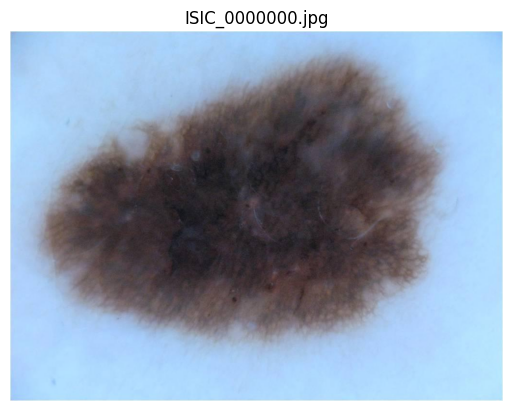

In [6]:
import matplotlib.pyplot as plt
import cv2

p = nevus_imgs[0]
img = cv2.imread(p)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img_rgb)
plt.title(os.path.basename(p))
plt.axis("off")
plt.show()


In [7]:
import os, glob, cv2, numpy as np, pandas as pd

PROJECT_DIR = r"C:\Users\jakub\melanoma-project"
NEVUS_DIR = os.path.join(PROJECT_DIR, "data", "raw", "nevus")
MEL_DIR   = os.path.join(PROJECT_DIR, "data", "raw", "melanoma")

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

def list_images(folder):
    files = glob.glob(os.path.join(folder, "**", "*"), recursive=True)
    return sorted([f for f in files if f.lower().endswith(IMG_EXTS)])

nevus_imgs = list_images(NEVUS_DIR)
mel_imgs   = list_images(MEL_DIR)

print("Nevus images:", len(nevus_imgs))
print("Melanoma images:", len(mel_imgs))


Nevus images: 500
Melanoma images: 500


In [9]:
!pip install scikit-image


In [10]:
from skimage import feature, measure
import cv2
import numpy as np

def segment_lesion(bgr_img):
    img = cv2.resize(bgr_img, (256, 256), interpolation=cv2.INTER_AREA)
    blur = cv2.GaussianBlur(img, (5,5), 0)

    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
    v = hsv[..., 2]

    _, th = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if th.mean() > 127:
        th = cv2.bitwise_not(th)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, k, iterations=1)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k, iterations=2)

    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(th)
    if not contours:
        return img, mask

    c = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [c], -1, 255, thickness=-1)
    return img, mask

def circularity(area, perimeter):
    if perimeter <= 1e-6: return np.nan
    return float(4*np.pi*area/(perimeter*perimeter))

def border_irregularity(area, perimeter):
    if area <= 1e-6: return np.nan
    return float((perimeter*perimeter)/(4*np.pi*area))  # 1 = koło, większe = bardziej nieregularne

def asymmetry(mask):
    m = (mask > 0).astype(np.uint8)
    if m.sum() == 0: return np.nan
    rot = cv2.rotate(m, cv2.ROTATE_180)
    diff = np.abs(m.astype(np.int16) - rot.astype(np.int16))
    return float(diff.sum() / m.sum())

def extract_features(bgr_img):
    img, mask = segment_lesion(bgr_img)
    m = (mask > 0).astype(np.uint8)
    if m.sum() == 0:
        return {k: np.nan for k in [
            "circularity","border_irregularity","asymmetry","eccentricity","solidity",
            "mean_r","mean_g","mean_b","hue_std","lbp_entropy"
        ]}

    lbl = measure.label(m, connectivity=2)
    p = max(measure.regionprops(lbl), key=lambda x: x.area)

    area = float(p.area)
    perimeter = float(getattr(p, "perimeter", np.nan))
    ecc = float(getattr(p, "eccentricity", np.nan))
    sol = float(getattr(p, "solidity", np.nan))

    # kolor
    pix = img[m > 0].reshape(-1,3).astype(np.float32)  # BGR
    mean_b, mean_g, mean_r = pix.mean(axis=0)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv[...,0][m > 0].astype(np.float32)
    hue_std = float(np.std(h))

    # tekstura (LBP entropy)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_vals = lbp[m > 0]
    hist, _ = np.histogram(lbp_vals, bins=np.arange(0, 12), density=True)
    lbp_entropy = float(-(hist * np.log(hist + 1e-12)).sum())

    return {
        "circularity": circularity(area, perimeter),
        "border_irregularity": border_irregularity(area, perimeter),
        "asymmetry": asymmetry(mask),
        "eccentricity": ecc,
        "solidity": sol,
        "mean_r": float(mean_r), "mean_g": float(mean_g), "mean_b": float(mean_b),
        "hue_std": hue_std,
        "lbp_entropy": lbp_entropy,
    }


In [11]:
print("segment_lesion:", segment_lesion)
print("extract_features:", extract_features)


segment_lesion: <function segment_lesion at 0x000001C445DAE200>
extract_features: <function extract_features at 0x000001C449E62B90>


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

rng = np.random.default_rng(42)
nev_sample = rng.choice(nevus_imgs, size=min(500, len(nevus_imgs)), replace=False)
mel_sample = rng.choice(mel_imgs,   size=min(500, len(mel_imgs)),   replace=False)

rows = []
for p in nev_sample:
    img = cv2.imread(p)
    if img is None: 
        continue
    f = extract_features(img)
    f["label"] = 0
    f["path"] = p
    rows.append(f)

for p in mel_sample:
    img = cv2.imread(p)
    if img is None:
        continue
    f = extract_features(img)
    f["label"] = 1
    f["path"] = p
    rows.append(f)

df = pd.DataFrame(rows)
print("Rows:", df.shape)
print("NaNs total:", int(df.isna().sum().sum()))

X = df.drop(columns=["label","path"])
y = df["label"].astype(int)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=800, class_weight="balanced", random_state=42, n_jobs=-1))
])

pipe.fit(Xtr, ytr)

proba = pipe.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(yte, proba))
print(confusion_matrix(yte, pred))
print(classification_report(yte, pred, digits=4))


Rows: (1000, 12)
NaNs total: 0
ROC-AUC: 0.8494000000000002
[[77 23]
 [29 71]]
              precision    recall  f1-score   support

           0     0.7264    0.7700    0.7476       100
           1     0.7553    0.7100    0.7320       100

    accuracy                         0.7400       200
   macro avg     0.7409    0.7400    0.7398       200
weighted avg     0.7409    0.7400    0.7398       200



In [13]:
def predict_one(image_path, threshold=0.5):
    img = cv2.imread(image_path)
    feats = extract_features(img)
    X1 = pd.DataFrame([feats])
    p = float(pipe.predict_proba(X1)[0, 1])
    return {
        "melanoma_proba": p,
        "pred_label": int(p >= threshold),
        "pred_name": "melanoma" if p >= threshold else "nevus"
    }

out = predict_one(nevus_imgs[0])
out


{'melanoma_proba': 0.1475, 'pred_label': 0, 'pred_name': 'nevus'}

In [14]:
out = predict_one(mel_imgs[0])
out


{'melanoma_proba': 0.725, 'pred_label': 1, 'pred_name': 'melanoma'}

In [15]:
import numpy as np
p = np.random.choice(mel_imgs)
print("Test path:", p)
print(predict_one(p))


Test path: C:\Users\jakub\melanoma-project\data\raw\melanoma\ISIC_0010174.jpg
{'melanoma_proba': 0.89875, 'pred_label': 1, 'pred_name': 'melanoma'}


In [16]:
p = r"C:\Users\jakub\Desktop\melanomalubnevus.jpg"
predict_one(p)


{'melanoma_proba': 0.85125, 'pred_label': 1, 'pred_name': 'melanoma'}

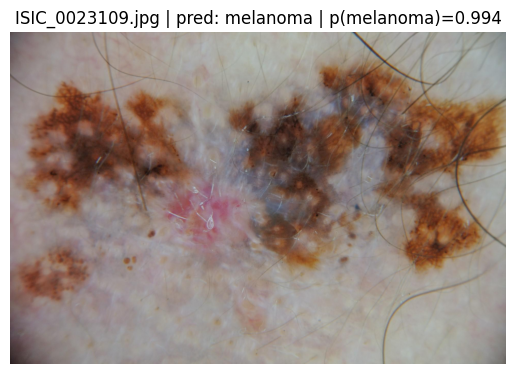

{'melanoma_proba': 0.99375, 'pred_label': 1, 'pred_name': 'melanoma'}

In [17]:
import matplotlib.pyplot as plt
import cv2, os

p = np.random.choice(mel_imgs)
res = predict_one(p)

img = cv2.imread(p)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{os.path.basename(p)} | pred: {res['pred_name']} | p(melanoma)={res['melanoma_proba']:.3f}")
plt.show()

res


In [18]:
for p in list(np.random.choice(nevus_imgs, 5, replace=False)) + list(np.random.choice(mel_imgs, 5, replace=False)):
    r = predict_one(p)
    print(os.path.basename(p), "->", r["pred_name"], "p=", round(r["melanoma_proba"], 3))


ISIC_0000205.jpg -> nevus p= 0.089
ISIC_0000574.jpg -> nevus p= 0.071
ISIC_0000453.jpg -> nevus p= 0.069
ISIC_0000497.jpg -> nevus p= 0.115
ISIC_0000267.jpg -> melanoma p= 0.929
ISIC_0012633.jpg -> melanoma p= 0.964
ISIC_0011042.jpg -> melanoma p= 0.943
ISIC_0022254.jpg -> melanoma p= 0.927
ISIC_0021147.jpg -> melanoma p= 0.95
ISIC_0022383.jpg -> melanoma p= 0.686


In [19]:
import cv2
import numpy as np
from skimage import feature, measure

def preprocess_gray(bgr_img):
    img = cv2.resize(bgr_img, (256, 256), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    return img, gray

def segment_lesion_gray(bgr_img):
    img, gray = preprocess_gray(bgr_img)

    # Otsu na grayscale
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # jeśli tło wyszło jako "zmiana", odwróć
    if th.mean() > 127:
        th = cv2.bitwise_not(th)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, k, iterations=1)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k, iterations=2)

    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(th)
    if not contours:
        return img, gray, mask

    c = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [c], -1, 255, thickness=-1)
    return img, gray, mask

def circularity(area, perimeter):
    if perimeter <= 1e-6: return np.nan
    return float(4*np.pi*area/(perimeter*perimeter))

def border_irregularity(area, perimeter):
    if area <= 1e-6: return np.nan
    return float((perimeter*perimeter)/(4*np.pi*area))  # 1=koło, >1 bardziej poszarpane

def asymmetry(mask):
    m = (mask > 0).astype(np.uint8)
    if m.sum() == 0: return np.nan
    rot = cv2.rotate(m, cv2.ROTATE_180)
    diff = np.abs(m.astype(np.int16) - rot.astype(np.int16))
    return float(diff.sum() / m.sum())

def extract_features(bgr_img):
    img, gray, mask = segment_lesion_gray(bgr_img)
    m = (mask > 0).astype(np.uint8)
    if m.sum() == 0:
        return {k: np.nan for k in [
            "circularity","border_irregularity","asymmetry","eccentricity","solidity",
            "lbp_entropy","glcm_contrast","glcm_homogeneity"
        ]}

    lbl = measure.label(m, connectivity=2)
    p = max(measure.regionprops(lbl), key=lambda x: x.area)

    area = float(p.area)
    perimeter = float(getattr(p, "perimeter", np.nan))
    ecc = float(getattr(p, "eccentricity", np.nan))
    sol = float(getattr(p, "solidity", np.nan))

    # LBP entropy (tekstura)
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_vals = lbp[m > 0]
    hist, _ = np.histogram(lbp_vals, bins=np.arange(0, 12), density=True)
    lbp_entropy = float(-(hist * np.log(hist + 1e-12)).sum())

    # GLCM (tekstura) na bbox
    minr, minc, maxr, maxc = p.bbox
    crop = gray[minr:maxr, minc:maxc]
    crop_m = m[minr:maxr, minc:maxc]
    med = int(np.median(crop[crop_m > 0])) if np.any(crop_m > 0) else int(np.median(crop))
    crop2 = crop.copy()
    crop2[crop_m == 0] = med
    crop2 = (crop2 / 8).astype(np.uint8)  # levels=32
    glcm = feature.graycomatrix(crop2, distances=[1], angles=[0], levels=32, symmetric=True, normed=True)
    glcm_contrast = float(feature.graycoprops(glcm, "contrast")[0, 0])
    glcm_homogeneity = float(feature.graycoprops(glcm, "homogeneity")[0, 0])

    return {
        "circularity": circularity(area, perimeter),
        "border_irregularity": border_irregularity(area, perimeter),
        "asymmetry": asymmetry(mask),
        "eccentricity": ecc,
        "solidity": sol,
        "lbp_entropy": lbp_entropy,
        "glcm_contrast": glcm_contrast,
        "glcm_homogeneity": glcm_homogeneity,
    }


In [20]:
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# === 1) próbka (żeby było szybko i równo klasami) ===
rng = np.random.default_rng(42)
nev_sample = rng.choice(nevus_imgs, size=min(500, len(nevus_imgs)), replace=False)
mel_sample = rng.choice(mel_imgs,   size=min(500, len(mel_imgs)),   replace=False)

# === 2) budowa tabeli cech ===
rows = []

for p in nev_sample:
    img = cv2.imread(p)
    if img is None:
        continue
    f = extract_features(img)
    f["label"] = 0
    f["path"] = p
    rows.append(f)

for p in mel_sample:
    img = cv2.imread(p)
    if img is None:
        continue
    f = extract_features(img)
    f["label"] = 1
    f["path"] = p
    rows.append(f)

df = pd.DataFrame(rows)

print("Rows:", df.shape)
print("NaNs total:", int(df.isna().sum().sum()))
display(df.head())

# === 3) train/test split ===
X = df.drop(columns=["label", "path"])
y = df["label"].astype(int)

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 4) model (imputer + RandomForest) ===
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=800,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

pipe.fit(Xtr, ytr)

# === 5) ewaluacja ===
proba = pipe.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(yte, proba))
print("Confusion matrix:\n", confusion_matrix(yte, pred))
print(classification_report(yte, pred, digits=4))


Rows: (1000, 10)
NaNs total: 0


,circularity,border_irregularity,asymmetry,eccentricity,solidity,lbp_entropy,glcm_contrast,glcm_homogeneity,label,path
0,0.727161,1.375211,0.191079,0.741869,0.942440,1.525903,0.673406,0.891022,0,C:\Users\jakub\melanoma-project\data\raw\nevus...
1,0.830064,1.204727,1.476793,0.690757,0.983750,2.046123,0.258878,0.901135,0,C:\Users\jakub\melanoma-project\data\raw\nevus...
2,0.680323,1.469889,2.000000,0.562978,0.903205,1.711830,0.207406,0.914562,0,C:\Users\jakub\melanoma-project\data\raw\nevus...
3,0.383811,2.605451,2.000000,0.915495,0.863864,2.018298,0.197568,0.913781,0,C:\Users\jakub\melanoma-project\data\raw\nevus...
4,0.861873,1.160264,0.073090,0.349270,0.993923,1.670173,0.385175,0.853431,0,C:\Users\jakub\melanoma-project\data\raw\nevus...


ROC-AUC: 0.8375499999999999
Confusion matrix:
 [[76 24]
 [18 82]]
              precision    recall  f1-score   support

           0     0.8085    0.7600    0.7835       100
           1     0.7736    0.8200    0.7961       100

    accuracy                         0.7900       200
   macro avg     0.7910    0.7900    0.7898       200
weighted avg     0.7910    0.7900    0.7898       200



In [21]:
def predict_one(image_path, threshold=0.5):
    img = cv2.imread(image_path)
    feats = extract_features(img)
    X1 = pd.DataFrame([feats])
    p = float(pipe.predict_proba(X1)[0, 1])  # prawdopodobieństwo czerniaka
    return {
        "melanoma_proba": p,
        "pred_label": int(p >= threshold),
        "pred_name": "melanoma" if p >= threshold else "nevus"
    }

# przykład
out = predict_one(nevus_imgs[0])
out


{'melanoma_proba': 0.10625, 'pred_label': 0, 'pred_name': 'nevus'}

In [24]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

def generate_explanation_figure(image_path, out_dir="outputs", topk=6, threshold=0.5):
    os.makedirs(out_dir, exist_ok=True)

    bgr = cv2.imread(image_path)
    if bgr is None:
        raise ValueError(f"Nie mogę wczytać obrazu: {image_path}")

    # segmentacja + podglądy
    img, gray, mask = segment_lesion_gray(bgr)

    overlay = img.copy()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)

    edges = cv2.Canny(gray, 50, 150)
    edges_in = cv2.bitwise_and(edges, edges, mask=mask)

    # cechy + predykcja
    feats = extract_features(bgr)
    feat_names = list(feats.keys())
    X1 = pd.DataFrame([feats], columns=feat_names)

    p_mel = float(pipe.predict_proba(X1)[0, 1])
    pred_name = "melanoma" if p_mel >= threshold else "nevus"

    # TOP cechy wg ważności
    clf = pipe.named_steps.get("clf", None)
    top_lines = []
    if clf is not None and hasattr(clf, "feature_importances_"):
        imps = np.array(clf.feature_importances_, dtype=float)
        if len(imps) == len(feat_names):
            idx = np.argsort(imps)[::-1][:topk]
            for i in idx:
                name = feat_names[i]
                val = feats.get(name, np.nan)
                val_str = "NaN" if (isinstance(val, float) and np.isnan(val)) else f"{float(val):.4f}"
                top_lines.append(f"{name:18s} = {val_str:>8s}   | imp={imps[i]:.4f}")
        else:
            for name in feat_names[:topk]:
                val = feats.get(name, np.nan)
                top_lines.append(f"{name} = {val}")
    else:
        for name in feat_names[:topk]:
            val = feats.get(name, np.nan)
            val_str = "NaN" if (isinstance(val, float) and np.isnan(val)) else f"{float(val):.4f}"
            top_lines.append(f"{name:18s} = {val_str}")

    # --- layout: 2x2 + dolny panel tekstowy ---
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.55], hspace=0.25, wspace=0.15)

    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title("Oryginał")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0,1])
    ax2.imshow(gray, cmap="gray")
    ax2.set_title("Czarno-biały (grayscale)")
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[1,0])
    ax3.imshow(mask, cmap="gray")
    ax3.set_title("Maska zmiany")
    ax3.axis("off")

    ax4 = fig.add_subplot(gs[1,1])
    ax4.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    ax4.imshow(edges_in, cmap="gray", alpha=0.35)
    ax4.set_title("Kontur + krawędzie (Canny) w masce")
    ax4.axis("off")

    ax_text = fig.add_subplot(gs[2,:])
    ax_text.axis("off")
    text = (
        f"Plik: {os.path.basename(image_path)}\n"
        f"Predykcja: {pred_name}   |   p(melanoma)={p_mel:.3f}\n\n"
        f"TOP cechy (wartość + ważność modelu):\n" +
        "\n".join(top_lines)
    )
    ax_text.text(0.01, 0.98, text, va="top", ha="left", family="monospace", fontsize=11)

    fig.suptitle(f"{os.path.basename(image_path)} | pred: {pred_name} | p(melanoma)={p_mel:.3f}", fontsize=14)

    out_path = os.path.join(out_dir, f"explain_{os.path.splitext(os.path.basename(image_path))[0]}_{pred_name}_{p_mel:.3f}.png")
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.show()

    return {"pred": pred_name, "p_melanoma": p_mel, "out_path": out_path}


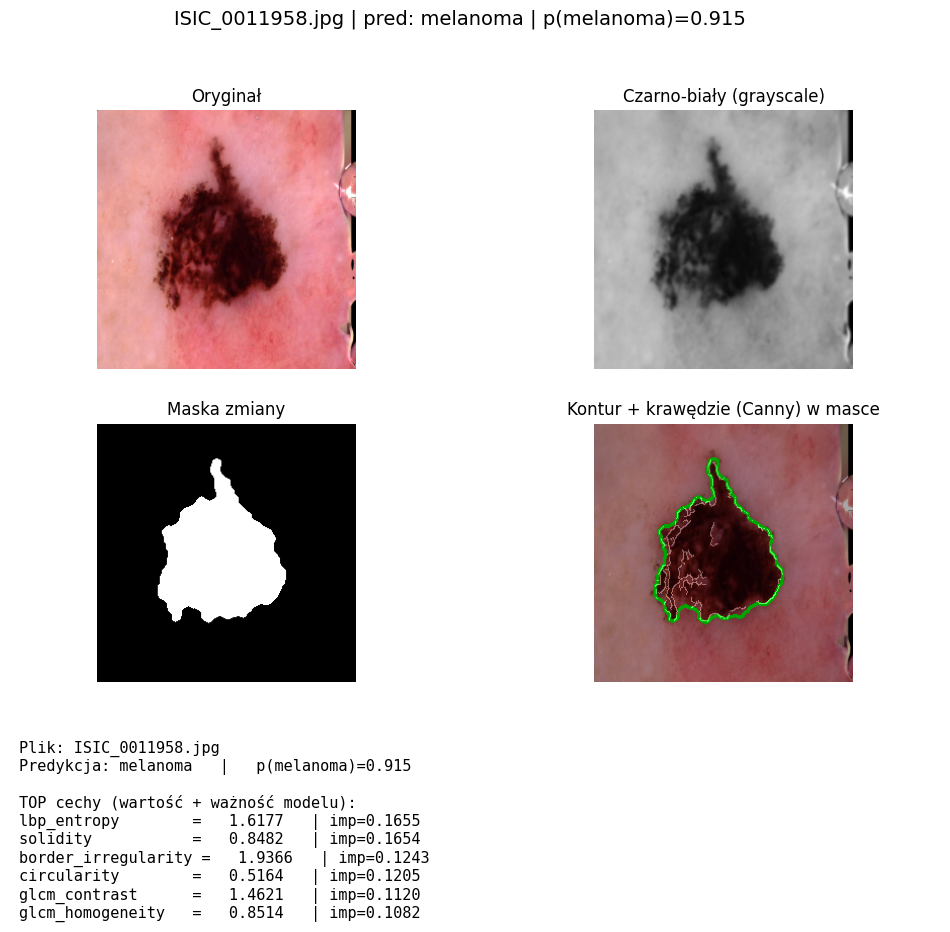

{'pred': 'melanoma',
 'p_melanoma': 0.915,
 'out_path': 'outputs\\explain_ISIC_0011958_melanoma_0.915.png'}

In [42]:
import numpy as np
p = np.random.choice(mel_imgs)  # albo nevus_imgs
res = generate_explanation_figure(p)
res
